In [34]:
import pandas as pd

file_path = '/Users/vee/Desktop/haensel_ams_mmm_project/MMM_test_data.csv'
df = pd.read_csv(file_path)
df.head()


,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


In [35]:
df.info

<bound method DataFrame.info of     start_of_week    revenue  spend_channel_1  spend_channel_2  \
0        30-08-20  157906.75          2625.48           262.71   
1        06-09-20  186425.68          2634.01           108.66   
2        13-09-20  161607.39          2087.08           110.32   
3        20-09-20  180089.13          1690.70            52.79   
4        27-09-20  217793.98          1547.30            80.56   
..            ...        ...              ...              ...   
99       24-07-22   72021.50             0.00          1118.78   
100      31-07-22   90786.21             0.00           122.16   
101      07-08-22  105929.40             0.00           754.09   
102      14-08-22   90506.31             0.00          1043.22   
103      21-08-22   84394.50             0.00           387.94   

     spend_channel_3  spend_channel_4  spend_channel_5  spend_channel_6  \
0           12954.12          3609.63         12955.29         12659.12   
1            8760.28     

### Clean and Prepare the Data

In [ ]:
# Converting start of week to datetime format
df['start_of_week'] = pd.to_datetime(df['start_of_week'], format='%d-%m-%y')

df = df.sort_values(by='start_of_week').reset_index(drop=True)
df.head()


,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,2020-09-06,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


In [ ]:
print(df.isnull().sum()) 
print(f"Duplicates: {df.duplicated().sum()}")   


start_of_week      0
revenue            0
spend_channel_1    0
spend_channel_2    0
spend_channel_3    0
spend_channel_4    0
spend_channel_5    0
spend_channel_6    0
spend_channel_7    0
dtype: int64
Duplicates: 0


### EDA (Exploratory Data Analysis)

In [47]:
start_date = df['start_of_week'].min()
end_date = df['start_of_week'].max()

total_revenue = df['revenue'].sum()
number_of_weeks = len(df)
print(f"Data starts on: {start_date.strftime('%B %d, %Y')}")
print(f"Data ends on: {end_date.strftime('%B %d, %Y')}")
print(f"Total number of weeks: {number_of_weeks}")
print(f"Total revenue: €{total_revenue:,.2f}")
print(f"Average weekly revenue: €{total_revenue/number_of_weeks:,.2f}")

Data starts on: August 30, 2020
Data ends on: August 21, 2022
Total number of weeks: 104
Total revenue: €14,194,979.83
Average weekly revenue: €136,490.19


#### Revenue over time

In [39]:
import plotly.express as px

fig = px.line(df, x='start_of_week', y='revenue', title='Revenue Over Time')
fig.show()


/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



#### Revenue appears to fluctuate between $100K-$200K most weeks with occasional larger spikes

####  Spend by channel over time

In [40]:
fig = px.line(df, x='start_of_week', y=df.columns[2:], 
              title='Spend by Channel Over Time')
fig.show()


/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## Adstock Transformation to help model the delayed impact of marketing spend

In [ ]:
import numpy as np

def adstock_transform(spend, alpha):
    adstocked_spend = np.zeros_like(spend)
    adstocked_spend[0] = spend[0]
    
    for t in range(1, len(spend)):
        adstocked_spend[t] = spend[t] + alpha * adstocked_spend[t-1]
        
    return adstocked_spend

# Finding the optimal alpha for each channel
def find_optimal_alpha(spend, revenue, alpha_values):
    best_alpha = 0.7  # starting value
    best_correlation = 0
    
    for alpha in alpha_values:
        adstocked = adstock_transform(spend, alpha)
        correlation = abs(np.corrcoef(adstocked, revenue)[0, 1])
        
        if correlation > best_correlation:
            best_correlation = correlation
            best_alpha = alpha
    
    return best_alpha, best_correlation

# Testing a range of alpha values
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

channel_alphas = {}
for channel in ['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
                'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
                'spend_channel_7']:
    
    optimal_alpha, correlation = find_optimal_alpha(
        df[channel].values, 
        df['revenue'].values,
        alpha_values
    )
    
    channel_alphas[channel] = optimal_alpha
    print(f"{channel}: Optimal alpha = {optimal_alpha}, Correlation = {correlation:.4f}")

for channel, alpha in channel_alphas.items():
    df[channel + '_adstocked'] = adstock_transform(df[channel].values, alpha)

print("\nChannel-specific alphas:")
for channel, alpha in channel_alphas.items():
    print(f"{channel}: {alpha}") 

print("\nFirst few rows with optimized adstocked values:")
print(df.head())

spend_channel_1: Optimal alpha = 0.1, Correlation = 0.3219
spend_channel_2: Optimal alpha = 0.9, Correlation = 0.2392
spend_channel_3: Optimal alpha = 0.1, Correlation = 0.3801
spend_channel_4: Optimal alpha = 0.9, Correlation = 0.2661
spend_channel_5: Optimal alpha = 0.1, Correlation = 0.4152
spend_channel_6: Optimal alpha = 0.2, Correlation = 0.5241
spend_channel_7: Optimal alpha = 0.1, Correlation = 0.2378

Channel-specific alphas:
spend_channel_1: 0.1
spend_channel_2: 0.9
spend_channel_3: 0.1
spend_channel_4: 0.9
spend_channel_5: 0.1
spend_channel_6: 0.2
spend_channel_7: 0.1

First few rows with optimized adstocked values:
  start_of_week    revenue  spend_channel_1  spend_channel_2  spend_channel_3  \
0    2020-08-30  157906.75          2625.48           262.71         12954.12   
1    2020-09-06  186425.68          2634.01           108.66          8760.28   
2    2020-09-13  161607.39          2087.08           110.32          7155.42   
3    2020-09-20  180089.13          1690.

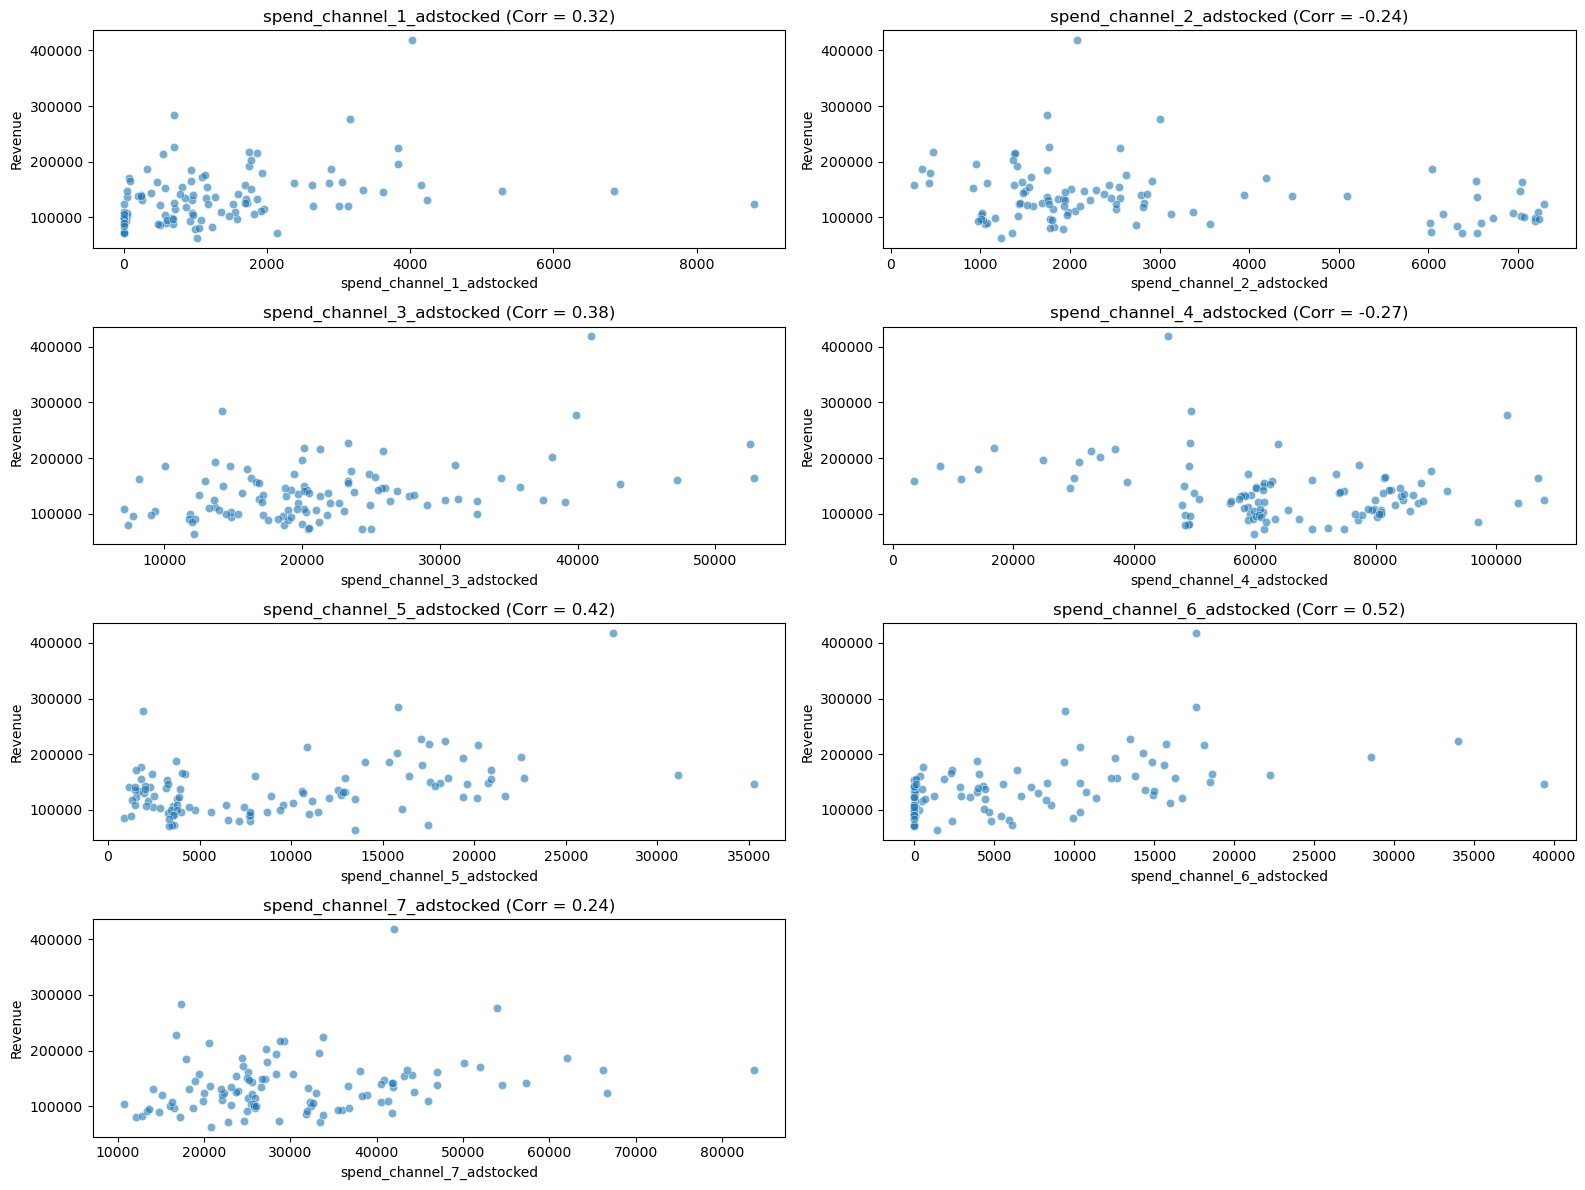

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

channels = [f'spend_channel_{i}_adstocked' for i in range(1, 8)]

plt.figure(figsize=(16, 12))
for i, channel in enumerate(channels):
    plt.subplot(4, 2, i + 1)
    sns.scatterplot(x=df[channel], y=df['revenue'], alpha=0.6)
    
    # Calculating correlation
    corr = np.corrcoef(df[channel], df['revenue'])[0, 1]
    
    plt.title(f'{channel} (Corr = {corr:.2f})')
    plt.xlabel(channel)
    plt.ylabel('Revenue')

plt.tight_layout()
plt.show()


#### Channel 6 (Corr = 0.52): Shows the strongest positive relationship with revenue - as adstocked spend increases, revenue tends to increase. This channel appears to be the most effective. Channel 6 stands out as the most effective driver of revenue — high correlation and consistent positive impact.

In [46]:
df.to_csv('marketing_data.csv', index=False)
